In [53]:
import gym
import  torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [54]:
#Hyperparameters
learning_rate=0.0002
gamma=0.98

# GYM
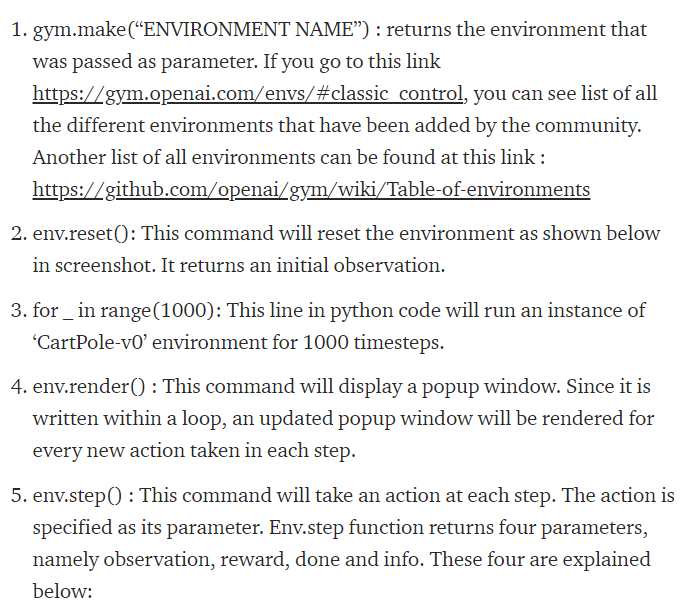

# Gym Cartpole output of step_function
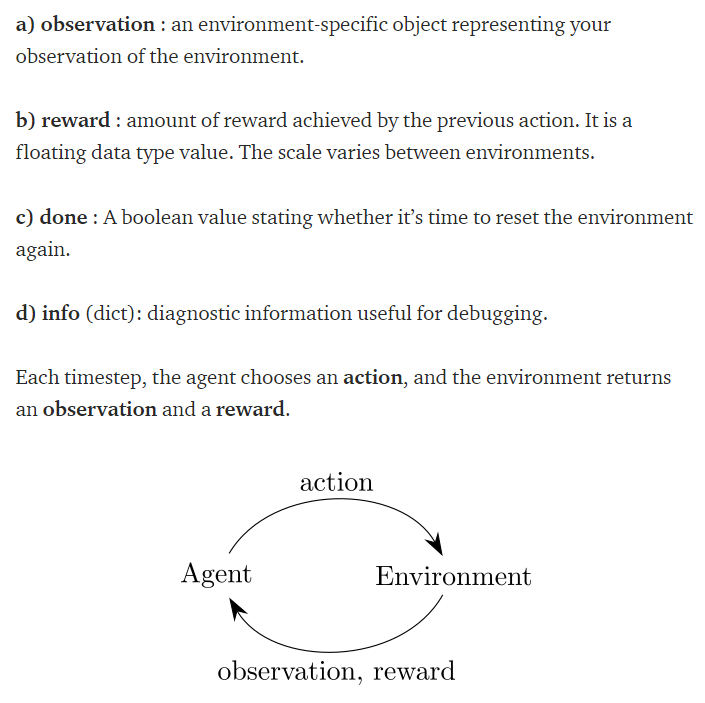

# Actor Critic One Body Network
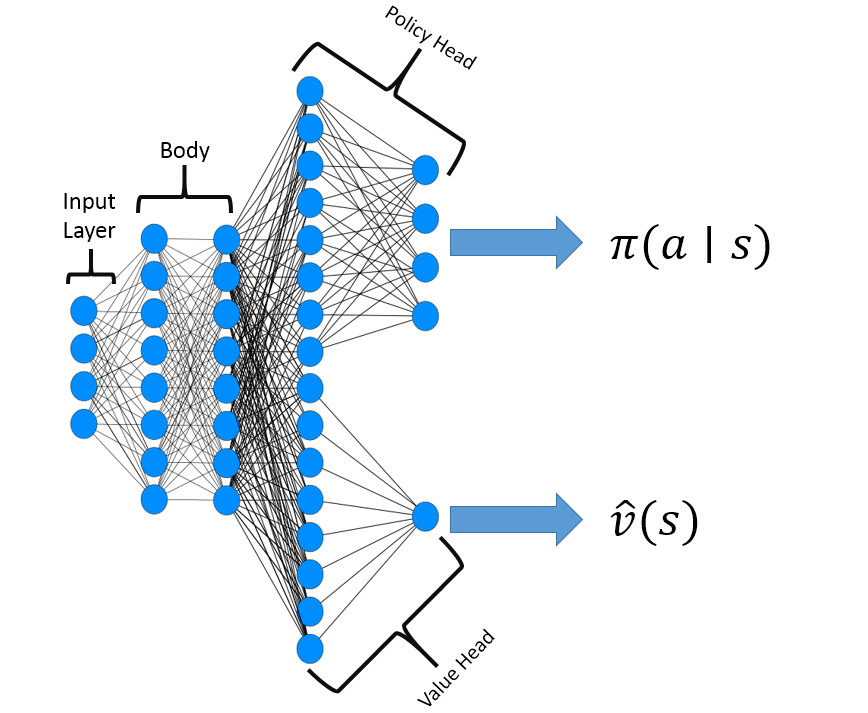

# Actor Critic Equation

## seperated Actor Critic Equation
$\bigtriangledown_\theta J(\theta) \approx  \frac{1}{M} \sum_{m=1}^{M} \bigtriangledown_\theta \log \pi_\theta (a_t | s_t) (r_t + \gamma V_\phi (s_{t+1})-V_\phi(s_t))$

$Loss(\phi)=0.5*(r_t + \gamma V_\phi (s_{t+1})-V_\phi(s_t))^2$

## Intergrated Actor Critic Loss Function

$loss=\frac{1}{M}\sum_{m=1}^{M} -\pi_\theta(a_t^{(m)} | s_t^{(m)})(r_t^{(m)}+V_\phi(s_{t+1}^{(m)}-V_\phi(s_t^{(m)}))+0.5(r_t^{(m)}+V_\phi(s_{t+1}^{(m)}-V_\phi(s_t^{(m)}))^2$

In [55]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic,self).__init__()
        self.data=list()
        self.fc1=nn.Linear(4,256)
        #Actor neural network
        self.fc_pi=nn.Linear(256,2)
        #Critic neural network
        self.fc_v=nn.Linear(256,1)
        self.optimizer=optim.Adam(self.parameters(),lr=learning_rate)
        
    def pi(self,x,softmax_dim=0):
        x=F.relu(self.fc1(x))
        x=self.fc_pi(x)
        prob=F.softmax(x,dim=softmax_dim)
        
        #[prob_of_action1,prob_of_action2]
        return prob
    
    def v(self,x):
        x=F.relu(self.fc1(x))
        v=self.fc_v(x)
        return v
    
    def put_data(self,transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst,a_lst,r_lst,s_prime_lst,done_lst=list(),list(),list(),list(),list()
        
        for transition in self.data:
            s,a,r,s_prime,done=transition
            #element들은 list 형태로 넣는다.
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.])
            s_prime_lst.append(s_prime)
            
            done=0.0 if done else 1.0
            done_lst.append([done])
            
        s_batch=torch.tensor(s_lst,dtype=torch.float)
        a_batch=torch.tensor(a_lst)
        r_batch=torch.tensor(r_lst,dtype=torch.float)
        s_prime_batch=torch.tensor(s_prime_lst,dtype=torch.float)
        done_batch=torch.tensor(done_lst,dtype=torch.float)
        
        
        self.data=list()
        # episode 초기화
        return s_batch,a_batch,r_batch,s_prime_batch,done_batch
    
    def train_net(self):
        
        s,a,r,s_prime,done=self.make_batch()
        td_target=r+gamma*self.v(s_prime)*done
        #죽은 episode는 과감히 버린다.
        delta=td_target-self.v(s)
        
        pi=self.pi(s,softmax_dim=1)
        pi_a=pi.gather(1,a)
        
        loss=-torch.log(pi_a)*delta.detach()+F.smooth_l1_loss(self.v(s),td_target.detach())
        # 2개의 신경망이 하나로 묶였기 때문에 어떤 걸 학습할 지 신중히 결정해야 한다.
        # 신경망을 주로 updating하는 것은 actor에게 맡겨야 하고 value는 마지막 자기 부분만 수정한다.
        # actor는 gradient ascent이기 때문에 -를 붙이고 value는 descent라 +를 유지한다.
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        #(s_t,a_t,r_t,s_{t+1}) tuple의 많은 묶음을 학습한 형태이기 때문에 mean으로 scalar로 만든다.
        self.optimizer.step()

In [56]:
# online training mode
def main():
    env=gym.make('CartPole-v1')
    model=ActorCritic()
    print_interval=20
    score=0.0
    
    for n_epi in range(1000):
        done=False
        #처음이거나 죽었을때 reset을 통해 다시 state를 정의한다.
        s=env.reset()
        while not done:


            prob=model.pi(torch.from_numpy(s).float())
            m=Categorical(prob)
            a=m.sample().item()
            s_prime,r,done,_=env.step(a)

            model.put_data((s,a,r,s_prime,done))

            s=s_prime
            score+=r
            #한 묶음이 완성되었기 때문에 학습이 가능하다.
            model.train_net()
            if done:
                break
        
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()
        

In [ ]:
if __name__ == '__main__':
    main()

# of episode :20, avg score : 34.6
# of episode :40, avg score : 31.9
# of episode :60, avg score : 53.0
# of episode :80, avg score : 108.2
# of episode :100, avg score : 173.7
# of episode :120, avg score : 126.3
# of episode :140, avg score : 104.8
# of episode :160, avg score : 104.5
# of episode :180, avg score : 123.5
# of episode :200, avg score : 214.8
# of episode :220, avg score : 241.0
# of episode :240, avg score : 212.6
# of episode :260, avg score : 245.8
# of episode :280, avg score : 301.8
# of episode :300, avg score : 443.7
# of episode :320, avg score : 433.4
# of episode :340, avg score : 462.6
# of episode :360, avg score : 266.1
# of episode :380, avg score : 197.9
# of episode :400, avg score : 291.0
# of episode :420, avg score : 364.2
# of episode :440, avg score : 481.9
# of episode :460, avg score : 396.1
# of episode :480, avg score : 428.4
# of episode :500, avg score : 455.0


In [ ]:
'''
# Batch training mode
def main():
    env=gym.make('CartPole-v1')
    model=ActorCritic()
    print_interval=20
    score=0.0
    
    for n_epi in range(1000):
        done=False
        #처음이거나 죽었을때 reset을 통해 다시 state를 정의한다.
        s=env.reset()
        while not done:


            prob=model.pi(torch.from_numpy(s).float())
            m=Categorical(prob)
            a=m.sample().item()
            s_prime,r,done,_=env.step(a)

            model.put_data((s,a,r,s_prime,done))

            s=s_prime
            score+=r
            #한 묶음이 완성되었기 때문에 학습이 가능하다.
            
            if done:
                break
        model.train_net()
        #모은 모든 묶음들을 학습에 이용하고 평균을 취해 tensor를 scalar로 만든다.
        장점: 빠르다.
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()
'''